# On metrics -- Advanced Notebook

This will get mathematical, be warned!

This notebook explores the mathematical foundations behind the metrics in
Exponax. We cover the consistency of discrete metrics with continuous functional
norms via the trapezoidal rule, the connection to Parseval's theorem and the
Fourier transform, the difference between various norm conventions ($p_2$, $l_2$,
$L_2$), and the role of Sobolev norms for measuring smoothness.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import exponax as ex
from exponax._spectral import (
    build_scaling_array,
    fft,
)

jax.config.update("jax_enable_x64", True)

%matplotlib inline

## Consistency of the metrics computation

The discretized states in exponax $u_h \in \mathbb{R}^{C \times N}$ represent
continuous functions sampled at an equidistant interval $\Delta x = L/N$ where
$L$ is the length of the domain and $N$ is the number of discretization points.
Since we only work with **periodic boundary conditions**, we employ the
convention that the left point of the domain is considered a degree of freedom
and the right point is not. Hence, $u_0$ refers to the value of the continuous
function at $u(0)$ and $u_{N-1}$ refers to the value of the continuous function
at $u(\frac{L}{N} (N-1))$.

Now assume, we wanted to compute the squared $L^2$ norm of the function $u(x)$ over the
domain $\Omega = (0, L)$

$$
\|u\|_{L^2(\Omega)}^2 = \int_{\Omega} |u(x)|^2 \; \mathrm{d}x
$$

A way to numerically approximate any integral with points given at equidistant
samples is via the trapezoidal rule. Assume we wanted to evaluate the following
integral

$$
I = \int_{0}^{L} f(x) \; \mathrm{d}x
$$

The trapezoidal rule states that

$$
I = \Delta x \left( \frac{f(0) + f(L)}{2} + \sum_{i=1}^{M-1} f(i \Delta x) \right) + \mathcal{O}(\Delta x^2)
$$

where $\Delta x = L/(M-1)$ is the distance between two consecutive points. In
contrast to our discretization on periodic grids, the trapezoidal rule also
accounts for the point on the right end of the domain. However, since the right
end of the domain must be equal to the value on the left end of the domain, we
have that $f(0) = f(L)$ and the trapezoidal rule simplifies to

$$
I = \Delta x \sum_{i=0}^{M-1} f(i \Delta x) + \mathcal{O}(\Delta x^2)
$$

Or if we had $f(x)$ discretized as $f_h \in \mathbb{R}^N$ where $f_h = f(i
\Delta x)$ with the periodic convention, we get

$$
I = \Delta x \sum_i f_i + \mathcal{O}(\Delta x^2)
$$

or expressed in terms of $L$ and $N$

$$
I = \frac{L}{N} \sum_i f_i + \mathcal{O}\left(N^{-2}\right)
$$

This is exactly as scaled mean

$$
I = L \; \text{mean}(f) + \mathcal{O}\left(N^{-2}\right)
$$

Since we actually wanted to evaluate the integral over the square absolute
function, we have that

$$
\|u\|_{L^2(\Omega)}^2 = \frac{L}{N} \sum_i |u_i|^2 + \mathcal{O}\left(N^{-2}\right)
$$

or again in terms of the mean

$$
\|u\|_{L^2(\Omega)}^2 = L \; \text{mean}(|u_h|^2) + \mathcal{O}\left(N^{-2}\right)
$$

Taking the mean over the element-wise squared is nothing else than the MSE (mean
squared error)

$$
\|u\|_{L^2(\Omega)}^2 = L \; \text{MSE}(u_h) + \mathcal{O}\left(N^{-2}\right)
$$

Hence, the consistent counterpart to the squared (functional) $L^2$ norm is the
**scaled** MSE.

For the regular $L^2$ norm, we have that

$$
\|u\|_{L^2(\Omega)} = \sqrt{\int_{\Omega} |u(x)|^2 \; \mathrm{d}x}
$$

As such, we get a consistent counterpart

$$
\|u\|_{L^2(\Omega)} = \sqrt{L \; \text{MSE}(u_h) + \mathcal{O}\left(N^{-2}\right)}
$$

Roughly, we can say that

$$
\|u\|_{L^2(\Omega)} \approx \sqrt{L \; \text{MSE}(u_h)} + \mathcal{O}\left(N^{-2}\right)
$$

And we can identify the RMSE as the consistent counterpart to the $L^2$ norm.

$$
\|u\|_{L^2(\Omega)} \approx \sqrt{L} \; \text{RMSE}(u_h) + \mathcal{O}\left(N^{-2}\right)
$$

It is scaled by the square root of the length of the domain.

### Requirements

The quadratic convergence on the MSE is only valid if the function is at least
twice continuously differentiable. In order to be that it must be that it also
periodic. In such a case, the estimate (might) even converges exponentially
(https://en.wikipedia.org/wiki/Trapezoidal_rule#Periodic_and_peak_functions)
fast!

As a consequence, a bandlimited discrete function representation (might) not
even have a discretization error at all!

On the other hand, if the function is not periodic, the estimate likely not
converges quadratically. It converges linearly
(https://en.wikipedia.org/wiki/Riemann_sum#Left_rule) if it is continuous which
is guaranteed by the periodicity assumption.

### Conclusion

Assuming we are on the periodic domain, we have:

- A bandlimited function is exactly integrated
- A non-bandlimited, but periodically continuous function converges
  exponentially linear (similar to how the spectral derivative converges)
- A discontinuous function converges linearly

Due the special case how periodic grids are layed out, we will never have the
case of quadratic convergence.

In [2]:
L = 2 * jnp.pi
N = 128
dx = L / N
grid = jnp.arange(N) * dx

# Bandlimited signal: sum of a few cosines
u = 3.0 * jnp.cos(grid) + 1.5 * jnp.cos(3 * grid) + 0.7 * jnp.cos(5 * grid)

# Manual trapezoidal rule: (L/N) * sum(|u|^2)
manual_mse = (L / N) * jnp.sum(u**2)

# Using exponax (needs leading channel axis)
u_ex = u[None, :]  # shape (1, N)
ex_mse = ex.metrics.MSE(u_ex, domain_extent=float(L))

print(f"Manual  (L/N)*sum(|u|^2) = {float(manual_mse):.10f}")
print(f"ex.metrics.MSE           = {float(ex_mse):.10f}")
print(f"Difference               = {float(jnp.abs(manual_mse - ex_mse)):.2e}")

Manual  (L/N)*sum(|u|^2) = 36.8822977531
ex.metrics.MSE           = 36.8822977531
Difference               = 0.00e+00


In [3]:
manual_rmse = jnp.sqrt(manual_mse)
ex_rmse = ex.metrics.RMSE(u_ex, domain_extent=float(L))

print(f"Manual  sqrt((L/N)*sum(|u|^2)) = {float(manual_rmse):.10f}")
print(f"ex.metrics.RMSE                = {float(ex_rmse):.10f}")

# Verify: RMSE = sqrt(L) * sqrt(mean(|u|^2))
ml_rmse = jnp.sqrt(jnp.mean(u**2))
print(f"\nsqrt(mean(u^2))        = {float(ml_rmse):.10f}")
print(f"sqrt(L) * sqrt(mean)   = {float(jnp.sqrt(L) * ml_rmse):.10f}")
print(f"ex.metrics.RMSE        = {float(ex_rmse):.10f}")

Manual  sqrt((L/N)*sum(|u|^2)) = 6.0730797585
ex.metrics.RMSE                = 6.0730797585

sqrt(mean(u^2))        = 2.4228082879
sqrt(L) * sqrt(mean)   = 6.0730797585
ex.metrics.RMSE        = 6.0730797585


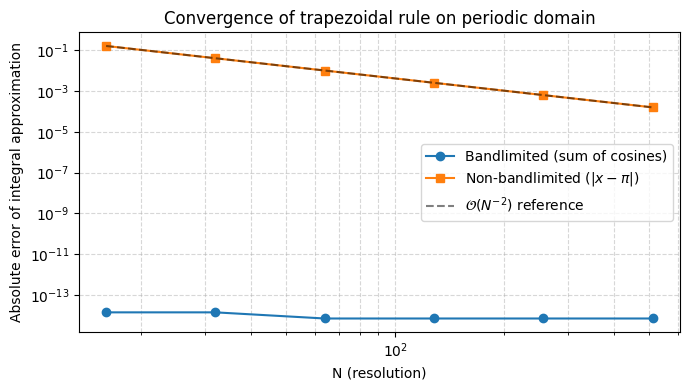

In [4]:
resolutions = [16, 32, 64, 128, 256, 512]

# (a) Bandlimited signal: analytic ||u||^2 = pi * (3^2 + 1.5^2 + 0.7^2)
# (cross terms integrate to zero, cos^2(kx) integrates to pi)
analytic_bl = jnp.pi * (3.0**2 + 1.5**2 + 0.7**2)

# (b) Non-bandlimited: u(x) = |x - pi|, continuous periodic with kinks
# int_0^{2pi} (x - pi)^2 dx = 2*pi^3/3
analytic_nbl = 2.0 * jnp.pi**3 / 3.0

errors_bl = []
errors_nbl = []

for N_i in resolutions:
    grid_i = jnp.arange(N_i) * (L / N_i)

    # Bandlimited
    u_bl = 3.0 * jnp.cos(grid_i) + 1.5 * jnp.cos(3 * grid_i) + 0.7 * jnp.cos(5 * grid_i)
    integral_bl = (L / N_i) * jnp.sum(u_bl**2)
    errors_bl.append(float(jnp.maximum(jnp.abs(integral_bl - analytic_bl), 1e-16)))

    # Non-bandlimited: |x - pi|
    u_nbl = jnp.abs(grid_i - jnp.pi)
    integral_nbl = (L / N_i) * jnp.sum(u_nbl**2)
    errors_nbl.append(float(jnp.abs(integral_nbl - analytic_nbl)))

plt.figure(figsize=(7, 4))
plt.loglog(resolutions, errors_bl, "o-", label="Bandlimited (sum of cosines)")
plt.loglog(resolutions, errors_nbl, "s-", label="Non-bandlimited ($|x - \\pi|$)")
# Reference line for N^{-2}
N_arr = jnp.array(resolutions, dtype=float)
plt.loglog(
    resolutions,
    float(errors_nbl[0]) * (N_arr / resolutions[0]) ** (-2),
    "k--",
    alpha=0.5,
    label="$\\mathcal{O}(N^{-2})$ reference",
)
plt.xlabel("N (resolution)")
plt.ylabel("Absolute error of integral approximation")
plt.title("Convergence of trapezoidal rule on periodic domain")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

### Mean-Average Error (MAE)

The MAE is consistent with the $L^1$ norm. By the same trapezoidal rule argument:

$$
\|u\|_{L^1(\Omega)} = \int_{\Omega} |u(x)| \; \mathrm{d}x \approx \frac{L}{N} \sum_i |u_i|
$$

In higher dimensions:

$$
\|u\|_{L^1(\Omega)} \approx \left(\frac{L}{N}\right)^D \sum_i |u_i|
$$

This is exactly the computation done by `ex.metrics.MAE`.

In [5]:
# Manual MAE (L1 norm)
manual_mae = (L / N) * jnp.sum(jnp.abs(u))
ex_mae = ex.metrics.MAE(u_ex, domain_extent=float(L))

print(f"Manual  (L/N)*sum(|u|) = {float(manual_mae):.10f}")
print(f"ex.metrics.MAE         = {float(ex_mae):.10f}")
print(f"Difference             = {float(jnp.abs(manual_mae - ex_mae)):.2e}")

Manual  (L/N)*sum(|u|) = 10.5583920029
ex.metrics.MAE         = 10.5583920029
Difference             = 0.00e+00


## Higher dimensions

In higher dimensions with a domain $\Omega = (0, L)^D$ with $D$ being the
number of spatial dimensions with the same convention for periodic boundary
conditions, we have that

$$
\|u\|_{L^2(\Omega)}^2 = \frac{L^D}{N^D} \sum_i |u_i|^2 + \mathcal{O}\left(N^{-2}\right)
$$

Assuming the $\text{mean}$ function takes the mean over the flattened axes with
$N^D$ elements, we have that

$$
\|u\|_{L^2(\Omega)}^2 = L^D \; \text{mean}(|u_h|^2) + \mathcal{O}\left(N^{-2}\right)
$$

or in terms of the MSE

$$
\|u\|_{L^2(\Omega)}^2 = L^D \; \text{MSE}(u_h) + \mathcal{O}\left(N^{-2}\right)
$$

Correspondingly, the RMSE is the consistent counterpart to the $L^2$ norm in

$$
\|u\|_{L^2(\Omega)} \approx \sqrt{L^D} \; \text{RMSE}(u_h) + \mathcal{O}\left(N^{-2}\right)
$$

In [6]:
N_2d = 64
grid_2d = jnp.arange(N_2d) * (L / N_2d)
X, Y = jnp.meshgrid(grid_2d, grid_2d, indexing="ij")
u_2d = 2.0 * jnp.cos(X) * jnp.cos(2 * Y) + jnp.sin(3 * X)

# Manual: (L/N)^2 * sum(|u|^2)
manual_mse_2d = (L / N_2d) ** 2 * jnp.sum(u_2d**2)

# Using exponax (needs leading channel axis)
u_2d_ex = u_2d[None, :, :]  # shape (1, N_2d, N_2d)
ex_mse_2d = ex.metrics.MSE(u_2d_ex, domain_extent=float(L))

print(f"Manual  (L/N)^2 * sum(|u|^2) = {float(manual_mse_2d):.10f}")
print(f"ex.metrics.MSE (2D)          = {float(ex_mse_2d):.10f}")
print(f"Difference                   = {float(jnp.abs(manual_mse_2d - ex_mse_2d)):.2e}")

Manual  (L/N)^2 * sum(|u|^2) = 59.2176264065
ex.metrics.MSE (2D)          = 59.2176264065
Difference                   = 0.00e+00


## Multiple Channels

If the underlying function is a vector-valued function $u(x) \in \mathbb{R}^C$,
we can compute the $L^2$ norm of the function as

$$
\|u\|_{L^2(\Omega)}^2 = \int_{\Omega} u(x)^T u(x) \; \mathrm{d}x
$$

Hence, the consistent MSE reads

$$
\|u\|_{L^2(\Omega)}^2 = L^D \; \text{MSE}(u_h^T u_h) + \mathcal{O}\left(N^{-2}\right)
$$

with the inner product being understand only over the leading channel axis.

In [ ]:
# 2-channel 1D vector field
u_ch1 = 3.0 * jnp.cos(grid) + 1.5 * jnp.sin(2 * grid)
u_ch2 = 2.0 * jnp.sin(grid) - 0.5 * jnp.cos(4 * grid)
u_vec = jnp.stack([u_ch1, u_ch2], axis=0)  # shape (2, N)

# MSE sums over channels: MSE(u_vec) = MSE(ch1) + MSE(ch2)
ex_mse_vec = ex.metrics.MSE(u_vec, domain_extent=float(L))
ex_mse_ch1 = ex.metrics.MSE(u_ch1[None, :], domain_extent=float(L))
ex_mse_ch2 = ex.metrics.MSE(u_ch2[None, :], domain_extent=float(L))

print(f"MSE(vector field)     = {float(ex_mse_vec):.10f}")
print(f"MSE(ch1) + MSE(ch2)   = {float(ex_mse_ch1 + ex_mse_ch2):.10f}")
diff = jnp.abs(ex_mse_vec - (ex_mse_ch1 + ex_mse_ch2))
print(f"Difference            = {float(diff):.2e}")

## Differences between $p_2$, $l_2$, and $L_2$ norms

There are three common "2-norms" that arise in numerical PDE / ML contexts. They
differ by scaling:

- **$p_2$ (Euclidean vector norm):** $\|x\|_{p_2} = \left(\sum_i
  |x_i|^2\right)^{1/2}$. No spatial context, just the Euclidean distance. This
  is what `jnp.linalg.norm(x)` computes.

- **$l_2$ (mean-based / ML norm):** $\|x\|_{l_2} = \left(\frac{1}{N^D}\sum_i
  |x_i|^2\right)^{1/2}$. This is `jnp.sqrt(jnp.mean(x**2))`, the standard
  RMSE in machine learning.

- **$L_2$ (functional norm):** $\|u\|_{L_2} = \left(\int |u|^2
  \mathrm{d}x\right)^{1/2} \approx \left(\left(\frac{L}{N}\right)^D \sum_i
  |u_i|^2\right)^{1/2}$. This is consistent with the continuous $L^2(\Omega)$
  norm and is what `ex.metrics.RMSE` computes.

They are related by:

$$
L_2 = \sqrt{L^D} \cdot l_2, \qquad p_2 = \sqrt{N^D} \cdot l_2
$$

**When does it matter?** Comparing metrics across different resolutions $N$ or
domain sizes $L$. If you double the resolution, $p_2$ changes by $\sqrt{2^D}$
but $L_2$ and $l_2$ stay (approximately) the same. If you double the domain,
$l_2$ stays the same but $L_2$ changes by $\sqrt{2^D}$.

In [ ]:
# Compare p_2, l_2, L_2 for the same array
p2 = jnp.sqrt(jnp.sum(u**2))
l2 = jnp.sqrt(jnp.mean(u**2))
L2 = jnp.sqrt((L / N) * jnp.sum(u**2))  # = RMSE

print(f"p_2 (Euclidean)    = {float(p2):.6f}")
print(f"l_2 (mean-based)   = {float(l2):.6f}")
print(f"L_2 (functional)   = {float(L2):.6f}")
print("\nScaling relations (D=1):")
sqrt_L_l2 = float(jnp.sqrt(L) * l2)
sqrt_N_l2 = float(jnp.sqrt(N) * l2)
print(f"  sqrt(L) * l_2  = {sqrt_L_l2:.6f}  (should equal L_2 = {float(L2):.6f})")
print(f"  sqrt(N) * l_2  = {sqrt_N_l2:.6f}  (should equal p_2 = {float(p2):.6f})")

## Parseval's Identity: Spatial and Fourier aggregator

Parseval's theorem states that the $L^2$ norm can be equivalently computed in
Fourier space:

$$
\|u\|_{L^2(\Omega)}^2 = \int_{\Omega} |u(x)|^2 \mathrm{d}x = \sum_k |\hat{u}_k|^2
$$

In the discrete setting with the `rfft` convention used by Exponax, the Fourier
coefficients $\hat{u}$ from `fft(u)` must be divided by a **scaling array** to
recover the true amplitudes. The `"reconstruction"` mode of
`build_scaling_array` provides the correct scaling for computing norms.

Conceptually, `ex.metrics.fourier_MSE` and `ex.metrics.MSE` compute the same
thing (for `inner_exponent=2`), but the Fourier variant additionally allows:

- **Frequency filtering** (`low`/`high` arguments): decompose the error by
  frequency band
- **Derivative-based metrics** (`derivative_order`): leads to Sobolev norms

However, they are only identical if the inner exponent is 2 (a consequence of
Parseval's identity being specific to the $L^2$ norm).

In [9]:
# Manual Parseval verification using raw FFT
u_hat = fft(u_ex)  # shape (1, N//2+1)
scaling_recon = build_scaling_array(1, N, mode="reconstruction")  # shape (1, N//2+1)

# fourier_MSE = (L/N) * sum(|u_hat|^2 / scaling_recon)
manual_fourier_mse = (L / N) * jnp.sum(jnp.abs(u_hat) ** 2 / scaling_recon)

print(f"Spatial MSE:                 {float(ex_mse):.10f}")
print(f"Manual Fourier MSE:          {float(manual_fourier_mse):.10f}")
print(f"Difference:                  {float(jnp.abs(ex_mse - manual_fourier_mse)):.2e}")

# Show what the scaling array looks like
print(f"\nScaling array (first 10 entries): {scaling_recon[0, :10]}")
print(f"Shape: {scaling_recon.shape}")

Spatial MSE:                 36.8822977531
Manual Fourier MSE:          36.8822977531
Difference:                  7.11e-15

Scaling array (first 10 entries): [128.  64.  64.  64.  64.  64.  64.  64.  64.  64.]
Shape: (1, 65)


In [ ]:
# Verify fourier_MSE == MSE for several signals
signals = {
    "cos(x)": jnp.cos(grid)[None, :],
    "sin(3x)": jnp.sin(3 * grid)[None, :],
    "sum of cosines": u_ex,
    "exp(cos(x))": jnp.exp(jnp.cos(grid))[None, :],
}

print("Signal                | spatial MSE     | fourier MSE     | difference")
print("-" * 75)
for name, sig in signals.items():
    s_mse = ex.metrics.MSE(sig, domain_extent=float(L))
    f_mse = ex.metrics.fourier_MSE(sig, domain_extent=float(L))
    diff = float(jnp.abs(s_mse - f_mse))
    print(f"{name:22s}| {float(s_mse):15.8f} | {float(f_mse):15.8f} | {diff:.2e}")

In [11]:
# Decompose MSE by frequency band (no spatial equivalent!)
fourier_mse_low = ex.metrics.fourier_MSE(u_ex, domain_extent=float(L), low=0, high=3)
fourier_mse_high = ex.metrics.fourier_MSE(
    u_ex, domain_extent=float(L), low=4, high=N // 2
)
fourier_mse_total = ex.metrics.fourier_MSE(u_ex, domain_extent=float(L))

print("Frequency band decomposition of MSE:")
print(f"  Low modes  (0-3):  {float(fourier_mse_low):.10f}")
print(f"  High modes (4+):   {float(fourier_mse_high):.10f}")
print(f"  Sum of parts:      {float(fourier_mse_low + fourier_mse_high):.10f}")
print(f"  Total fourier MSE: {float(fourier_mse_total):.10f}")

Frequency band decomposition of MSE:
  Low modes  (0-3):  35.3429173529
  High modes (4+):   1.5393804003
  Sum of parts:      36.8822977531
  Total fourier MSE: 36.8822977531


## The inner and outer exponent

The `spatial_aggregator` generalizes the MSE/MAE/RMSE family via two exponents:

$$
\left(\left(\frac{L}{N}\right)^D \sum_i |u_i|^p\right)^q
$$

Common metrics correspond to specific choices of $(p, q)$:

| $(p, q)$    | Metric | Functional norm          |
|-------------|--------|--------------------------|
| $(1, 1)$    | MAE    | $\|u\|_{L^1}$           |
| $(2, 1)$    | MSE    | $\|u\|_{L^2}^2$         |
| $(2, 1/2)$  | RMSE   | $\|u\|_{L^2}$           |

The default `outer_exponent` (when not specified) is $q = 1/p$, which yields a
valid norm: $\|u\|_{L^p}$.

In [12]:
u_no_ch = u  # no channel axis for spatial_aggregator

# MSE: (p=2, q=1)
agg_mse = ex.metrics.spatial_aggregator(
    u_no_ch, domain_extent=float(L), inner_exponent=2.0, outer_exponent=1.0
)
ref_mse = ex.metrics.MSE(u_ex, domain_extent=float(L))
print(f"spatial_aggregator(p=2, q=1)   = {float(agg_mse):.10f}")
print(f"ex.metrics.MSE                 = {float(ref_mse):.10f}")

# RMSE: (p=2, q=0.5)
agg_rmse = ex.metrics.spatial_aggregator(
    u_no_ch, domain_extent=float(L), inner_exponent=2.0, outer_exponent=0.5
)
ref_rmse = ex.metrics.RMSE(u_ex, domain_extent=float(L))
print(f"\nspatial_aggregator(p=2, q=0.5) = {float(agg_rmse):.10f}")
print(f"ex.metrics.RMSE                = {float(ref_rmse):.10f}")

# MAE: (p=1, q=1)
agg_mae = ex.metrics.spatial_aggregator(
    u_no_ch, domain_extent=float(L), inner_exponent=1.0, outer_exponent=1.0
)
ref_mae = ex.metrics.MAE(u_ex, domain_extent=float(L))
print(f"\nspatial_aggregator(p=1, q=1)   = {float(agg_mae):.10f}")
print(f"ex.metrics.MAE                 = {float(ref_mae):.10f}")

spatial_aggregator(p=2, q=1)   = 36.8822977531
ex.metrics.MSE                 = 36.8822977531

spatial_aggregator(p=2, q=0.5) = 6.0730797585
ex.metrics.RMSE                = 6.0730797585

spatial_aggregator(p=1, q=1)   = 10.5583920029
ex.metrics.MAE                 = 10.5583920029


## The power spectrum and its relation to MSE

The power spectrum $E(k)$ decomposes the signal energy by wavenumber. Exponax
provides `ex.get_spectrum(u, power=True)` which computes this spectrum with
proper normalization.

For 1D signals, Parseval's identity gives:

$$
\sum_k E(k) = \frac{1}{2} \text{mean}(u^2)
$$

This connects the spectrum to the MSE: since
$\text{MSE} = \frac{L}{N} \sum_i |u_i|^2 = L \cdot \text{mean}(u^2)$, we have

$$
\text{MSE} = 2L \sum_k E(k)
$$

A `GaussianRandomField` with `powerlaw_exponent=alpha` produces fields whose
power spectrum follows $E(k) \sim k^{-\alpha}$.

In [13]:
# Verify Parseval relation for power spectrum
spectrum = ex.get_spectrum(u_ex, power=True)  # shape (1, N//2+1)

parseval_lhs = jnp.sum(spectrum)
parseval_rhs = 0.5 * jnp.mean(u**2)

print(f"sum(power_spectrum)  = {float(parseval_lhs):.10f}")
print(f"0.5 * mean(u^2)     = {float(parseval_rhs):.10f}")
print(f"Difference           = {float(jnp.abs(parseval_lhs - parseval_rhs)):.2e}")

# Connection to MSE
print(f"\n2*L * sum(spectrum)  = {float(2 * L * parseval_lhs):.10f}")
print(f"MSE(u)               = {float(ex_mse):.10f}")

sum(power_spectrum)  = 2.9350000000
0.5 * mean(u^2)     = 2.9350000000
Difference           = 4.44e-16

2*L * sum(spectrum)  = 36.8822977531
MSE(u)               = 36.8822977531


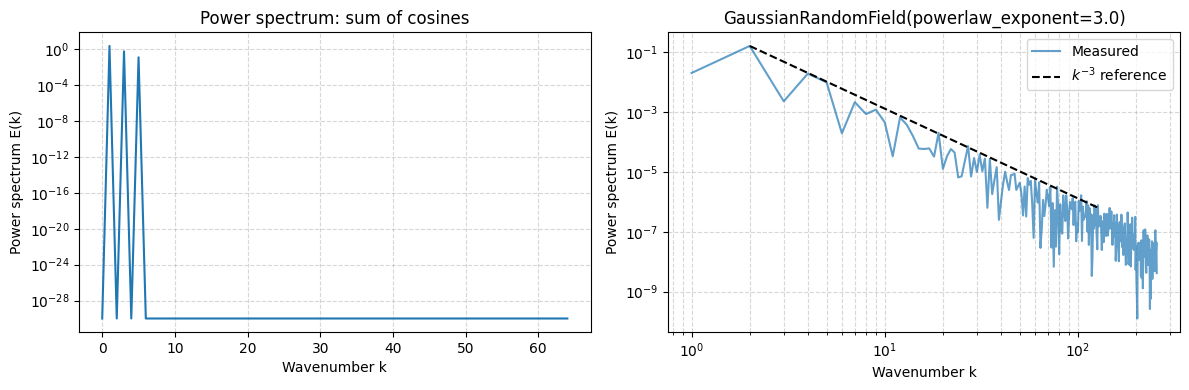

In [14]:
# Power spectrum of a GaussianRandomField
alpha = 3.0
grf = ex.ic.GaussianRandomField(
    1,
    domain_extent=float(L),
    powerlaw_exponent=alpha,
    zero_mean=True,
)
N_grf = 512
u_grf = grf(N_grf, key=jax.random.PRNGKey(42))  # shape (1, N_grf)
spectrum_grf = ex.get_spectrum(u_grf, power=True)  # shape (1, N_grf//2+1)

wavenumbers = jnp.arange(N_grf // 2 + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: power spectrum of our bandlimited test signal
axes[0].semilogy(jnp.arange(N // 2 + 1), jnp.maximum(spectrum[0], 1e-30))
axes[0].set_xlabel("Wavenumber k")
axes[0].set_ylabel("Power spectrum E(k)")
axes[0].set_title("Power spectrum: sum of cosines")
axes[0].grid(True, which="both", ls="--", alpha=0.5)

# Right: GRF power spectrum on log-log
axes[1].loglog(wavenumbers[1:], spectrum_grf[0, 1:], alpha=0.7, label="Measured")
k_ref = jnp.arange(2, N_grf // 4, dtype=float)
ref_amp = float(spectrum_grf[0, 2]) * (k_ref / 2.0) ** (-alpha)
axes[1].loglog(k_ref, ref_amp, "k--", label=f"$k^{{-{alpha:.0f}}}$ reference")
axes[1].set_xlabel("Wavenumber k")
axes[1].set_ylabel("Power spectrum E(k)")
axes[1].set_title(f"GaussianRandomField(powerlaw_exponent={alpha})")
axes[1].legend()
axes[1].grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

## Sobolev norms: the mathematical foundations

The Sobolev space $H^s(\Omega)$ extends the $L^2$ norm by also measuring
derivatives. The $H^s$ norm is defined as:

$$
\|u\|_{H^s}^2 = \sum_k (1 + |k|^2)^s |\hat{u}_k|^2
$$

For integer $s$, this has a more intuitive form. For $s = 1$:

$$
\|u\|_{H^1}^2 = \|u\|_{L^2}^2 + \|\nabla u\|_{L^2}^2
$$

This means the $H^1$ norm penalizes both the function values **and** their
gradients. Smooth fields have a small $H^1$ norm relative to their $L^2$ norm,
while rough/oscillatory fields have a large $H^1$ contribution from the gradient
term.

In Exponax, `ex.metrics.H1_MSE(u)` computes exactly this decomposition:

$$
\text{H1\_MSE}(u) = \text{fourier\_MSE}(u) + \text{fourier\_MSE}(u, \text{derivative\_order}=1)
$$

In [ ]:
# H1 norm decomposition
h1_mse = ex.metrics.H1_MSE(u_ex, domain_extent=float(L))
fourier_mse_base = ex.metrics.fourier_MSE(
    u_ex, domain_extent=float(L), derivative_order=None
)
fourier_mse_deriv = ex.metrics.fourier_MSE(
    u_ex, domain_extent=float(L), derivative_order=1
)

print("H1 norm decomposition:")
print(f"  fourier_MSE(deriv=None) = {float(fourier_mse_base):.10f}")
print(f"  fourier_MSE(deriv=1)    = {float(fourier_mse_deriv):.10f}")
h1_sum = float(fourier_mse_base + fourier_mse_deriv)
print(f"  Sum                     = {h1_sum:.10f}")
print(f"  H1_MSE                  = {float(h1_mse):.10f}")
h1_diff = float(jnp.abs(h1_mse - (fourier_mse_base + fourier_mse_deriv)))
print(f"  Difference              = {h1_diff:.2e}")

# Compare H1 vs L2 for smooth vs rough signals
u_smooth = jnp.sin(grid)[None, :]  # single low mode
u_rough = (jnp.sin(grid) + 0.5 * jnp.sin(20 * grid))[None, :]  # high-frequency content

for name, sig in [
    ("Smooth: sin(x)", u_smooth),
    ("Rough: sin(x) + 0.5*sin(20x)", u_rough),
]:
    l2 = ex.metrics.MSE(sig, domain_extent=float(L))
    h1 = ex.metrics.H1_MSE(sig, domain_extent=float(L))
    print(f"\n{name}:")
    print(f"  L2 (MSE)  = {float(l2):.6f}")
    print(f"  H1 (MSE)  = {float(h1):.6f}")
    print(f"  H1/L2     = {float(h1 / l2):.2f}")

## Convergence under refinement

As a final verification, we compute the MSE of known functions at increasing
resolutions and compare against analytic $L^2$ norms.

For $u(x) = \cos(x)$ on $\Omega = (0, 2\pi)$:

$$
\|u\|_{L^2}^2 = \int_0^{2\pi} \cos^2(x) \, \mathrm{d}x = \pi
$$

Since $\cos^2(x) = (1 + \cos(2x))/2$ is bandlimited, the trapezoidal rule gives
exact results at any resolution $N \geq 3$.

For a non-bandlimited function like $u(x) = \exp(\cos(x))$, the MSE converges
to the true integral as the resolution increases. For smooth periodic functions,
this convergence is exponentially fast.

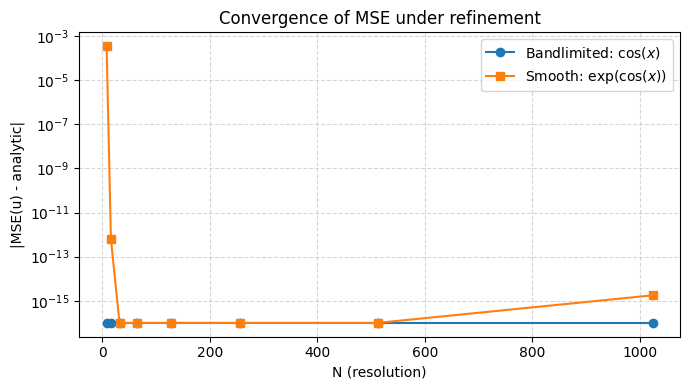

In [16]:
resolutions_conv = [8, 16, 32, 64, 128, 256, 512, 1024]

# Bandlimited: cos(x), ||u||^2 = pi
analytic_cos = jnp.pi

# Non-bandlimited: exp(cos(x)), use high-N reference
N_ref = 16384
grid_ref = jnp.arange(N_ref) * (L / N_ref)
analytic_exp = (L / N_ref) * jnp.sum(jnp.exp(jnp.cos(grid_ref)) ** 2)

errors_cos = []
errors_exp = []

for N_i in resolutions_conv:
    grid_i = jnp.arange(N_i) * (L / N_i)

    u_cos = jnp.cos(grid_i)[None, :]
    mse_cos = float(ex.metrics.MSE(u_cos, domain_extent=float(L)))
    errors_cos.append(max(abs(mse_cos - float(analytic_cos)), 1e-16))

    u_exp_i = jnp.exp(jnp.cos(grid_i))[None, :]
    mse_exp = float(ex.metrics.MSE(u_exp_i, domain_extent=float(L)))
    errors_exp.append(max(abs(mse_exp - float(analytic_exp)), 1e-16))

plt.figure(figsize=(7, 4))
plt.semilogy(resolutions_conv, errors_cos, "o-", label="Bandlimited: $\\cos(x)$")
plt.semilogy(resolutions_conv, errors_exp, "s-", label="Smooth: $\\exp(\\cos(x))$")
plt.xlabel("N (resolution)")
plt.ylabel("|MSE(u) - analytic|")
plt.title("Convergence of MSE under refinement")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()